In [330]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2.segment import get_seg_bboxes
import numpy as np
from PIL import Image

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from skimage import data, segmentation
from skimage import graph
from sklearn.cluster import KMeans
faiss = True
try:
    from faiss import Kmeans as fKMeans
except ImportError:
    faiss = False
from sklearn.metrics import calinski_harabasz_score

from skimage.color import rgb2hsv, label2rgb
import matplotlib.pyplot as plt
from time import time
from skimage.measure import label

from dataclasses import dataclass
from typing import Tuple

torch.manual_seed(2189)
np.random.seed(2189)


IMG_SIZE = 490
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

In [331]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [332]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')

fwd_flip, inv_flip = tr.get_flip_transforms()
#fwd, inv = fwd_flip, inv_flip
fwd, inv = fwd_shift, inv_shift
#fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
#fwd, inv = [], []
net.set_transforms(fwd, inv)

In [333]:
def get_dv2_features(net: HighResDV2, tensor: torch.Tensor, flatten: bool=True, sequential: bool=False) -> np.ndarray:
    # Given a HR-DV2 net with set transforms, get features. Either (c, h, w) or (h * w, c) depending on flatten.
    # Use sequential for high memory (large image and/or n_transforms) situations.
    if sequential:
        hr_tensor, _ = net.forward_sequential(tensor, attn='none')
    else:
        hr_tensor, _ = net.forward(tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    out: np.ndarray = features
    if flatten:
        out = features.reshape((c, fh * fw)).T
    return out

def do_pca(features: np.ndarray, k: int=3, standardize: bool=True) -> np.ndarray:
    # k component dimensionality reduction of (n_samples, n_channels) features.
    if standardize:
        features = standardize_img(features)
    pca = PCA(n_components=k, svd_solver='randomized', n_oversamples=5, iterated_power=3)
    pca.fit(features)
    projection = pca.transform(features)
    return projection

# helper functions for region adjancency merging later
def _weight_mean_color(graph, src, dst, n):
        diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
        diff = np.linalg.norm(diff)
        return {'weight': diff}
    
def _merge_mean_color(graph, src, dst):
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                    graph.nodes[dst]['pixel count'])


@dataclass
class CRFParams():
    label_confidence: float=0.6
    sxy_g: Tuple[int, int] = (3, 3)
    sxy_b: Tuple[int, int] = (80, 80)
    s_rgb: Tuple[int, int, int] = (13, 13, 13)
    compat_g: float = 10
    compat_b: float = 10
    n_infer: int = 10

KERNEL = dcrf.DIAG_KERNEL
default_crf_params = CRFParams()


def do_crf_from_labels(labels_arr: np.ndarray, img_arr: np.ndarray, n_classes: int, crf: CRFParams) -> np.ndarray:
    h, w, c = img_arr.shape
    unary = unary_from_labels(labels_arr, n_classes, crf.label_confidence, zero_unsure=False)
    d = dcrf.DenseCRF2D(w, h, n_classes)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=crf.sxy_g, compat=crf.compat_g, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=crf.sxy_b, srgb=crf.s_rgb, rgbim=img_arr, compat=crf.compat_b, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(crf.n_infer)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((h, w, 1))
    return crf_seg


In [334]:
def elbow(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, 
          clusters: List[int], verbose: bool=False) -> Tuple[List[np.ndarray], np.ndarray, np.ndarray, np.ndarray]:
    t0 = time()
    ih, iw, ic = img_arr.shape
    net.set_transforms([], [])
    attn, _ = net.forward(img_tensor, attn='cls')
    attn = tr.to_numpy(attn)
    t1 = time()
    if verbose:
        print(f"{t1-t0}s")
    net.set_transforms(fwd, inv)
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    t2 = time()
    if verbose:
        print(f"{t2-t1}s")
    reshaped = features.reshape((c, fh * fw)).T

    normed = normalise_pca(reshaped)
    

    labels, scores = [], []
    for n in clusters:
        cluster = KMeans(n_clusters=n, n_init='auto', max_iter=300)
        label = cluster.fit_predict(normed)
        #refined_seg = do_crf_from_labels(label, img_arr, n, default_crf_params)
        refined_seg = label
        score = calinski_harabasz_score(normed, label)
        print(score)
        labels.append(refined_seg)
        scores.append(score)
    

    t3 = time()
    if verbose:
        print(f"Finished in {t3-t0}s")
    return labels, attn, cluster.cluster_centers_, features

In [335]:
transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)

In [336]:
thresholds = np.arange(25, 200, 25)
clusters = [80]

path = "data/v7.png"
_img = Image.open(path)
h, w = _img.height, _img.width
if 'v' not in path:
    t = transform
else:
    t = tr.closest_crop(h, w, 14, True)
tensor, img = tr.load_image(path, t)
img_arr = np.array(img)


tensor.to(torch.float16)
tensor = tensor.cuda()

segs, attn, centres, features = elbow(net, img_arr, tensor, clusters, True)
tensor = tensor.cpu()

0.443925142288208s
4.853190898895264s
10920.069700707523
Finished in 21.28510618209839s


(2,)


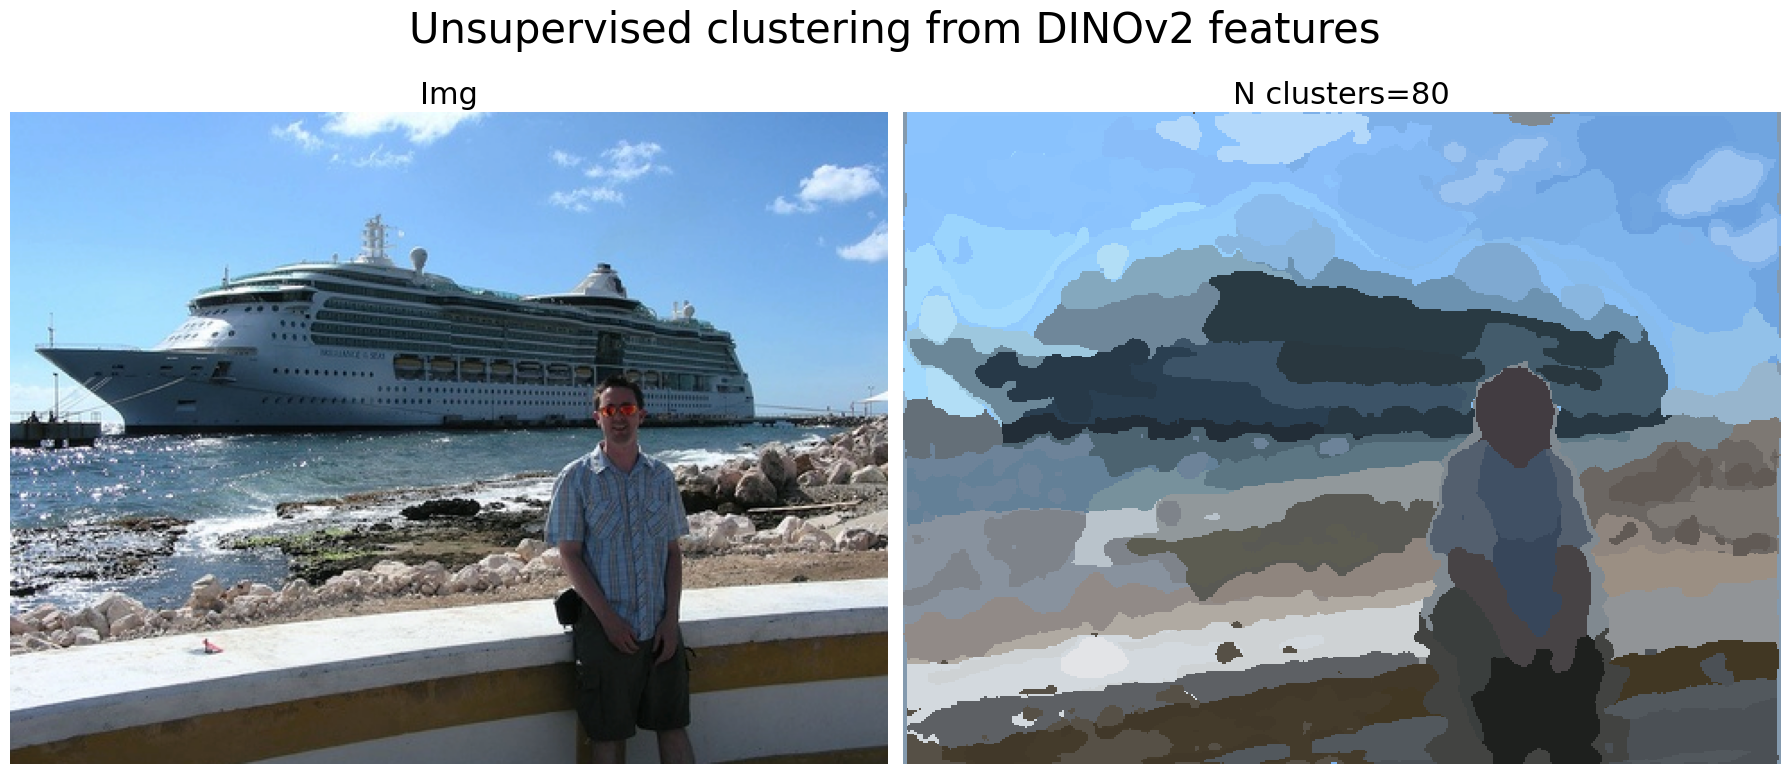

In [337]:
N_COLS = len(clusters) + 1
N_ROWS = 1
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(18, 8)
print(axs.shape)
ih, iw, c = img_arr.shape

plt.suptitle("Unsupervised clustering from DINOv2 features", fontsize=30, y=1.0)

I = 0
for j, arr in enumerate([img_arr] + segs):
    ax = axs[j]
    
    title = "Img"
    if j > 0:
        arr = arr.reshape((ih, iw)) + 1
        title = f"N clusters={clusters[j - 1]}"
        arr = label2rgb(arr, img_arr, kind='avg')
        ax.imshow(arr, cmap='tab20', interpolation='nearest')
    else:
        ax.imshow(arr)
    ax.set_title(title, fontsize=22)
    ax.set_axis_off()
plt.tight_layout()

In [338]:
sum_cls = np.sum(attn, axis=0)
labels2D = segs[0].reshape((ih, iw))
print(sum_cls.shape)

def get_attn_density(labels_arr: np.ndarray, attn: np.ndarray) -> Tuple[np.ndarray, List[float]]:
    densities = []
    attention_density_map = np.zeros_like(labels_arr).astype(np.float64)
    n_clusters = np.amax(labels_arr)
    for n in range(n_clusters):
        binary_mask = np.where(labels_arr == n, 1, 0)
        n_pix = np.sum(binary_mask)
        cluster_attn = np.sum(attn * binary_mask)
        cluster_attn_density = cluster_attn / n_pix
        densities.append(cluster_attn_density)
        attention_density_map += cluster_attn_density * binary_mask
    return attention_density_map, densities

density_map, densities = get_attn_density(labels2D, sum_cls)


(364, 490)


Text(0.5, 1.0, 'Foreground clusters')

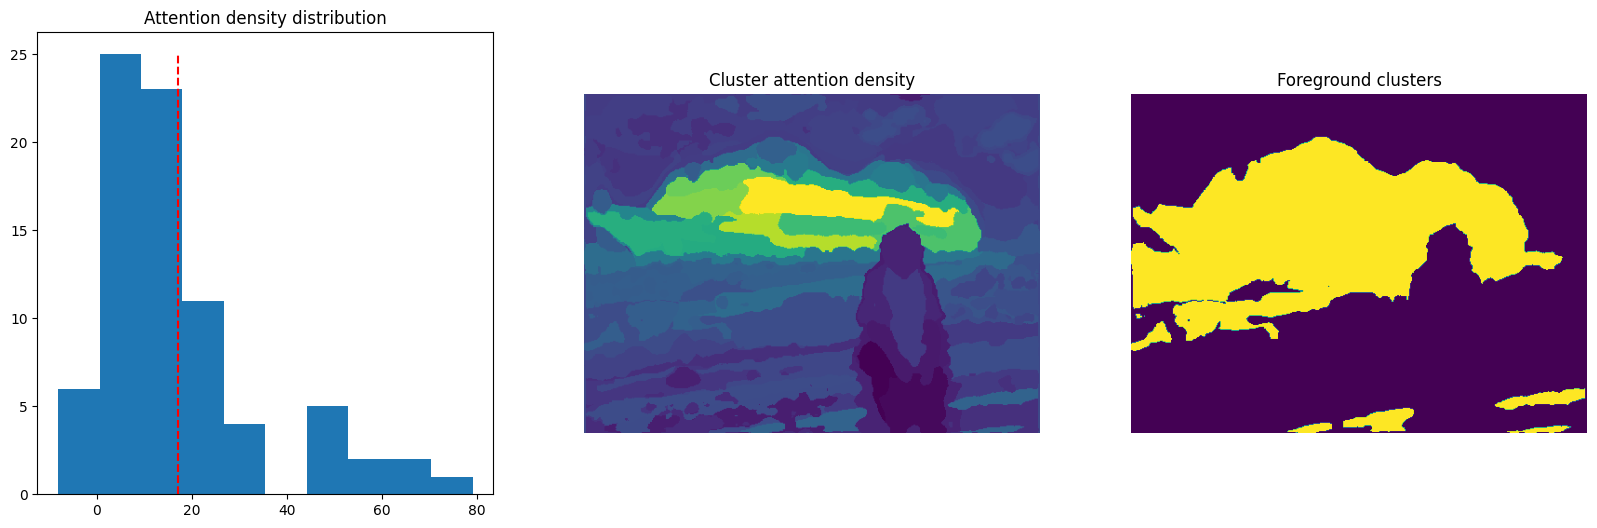

In [339]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 6)


n, bins, _ = axs[0].hist(densities)
max_loc = int(np.argmax(n))
#cutoff = bins[max_loc + 2] #max_loc + 2
axs[0].vlines(np.mean(densities), ymin=0, ymax=np.amax(n), colors=['red'], linestyles=['dashed'])
axs[0].set_title("Attention density distribution")

im = axs[1].imshow(density_map)
axs[1].set_axis_off()
axs[1].set_title("Cluster attention density")

fg_seg = (density_map > np.mean(densities)).astype(np.uint8)
axs[2].imshow(fg_seg)
axs[2].set_axis_off()
axs[2].set_title("Foreground clusters")

In [340]:
from skimage.measure import label

separated, n_components = label(fg_seg, return_num=True)
print(n_components, fg_seg.dtype)


out_mask = np.zeros((separated.shape[0], separated.shape[1], 1), dtype=np.int64)
for i in range(1, n_components + 1):
    current_obj = np.where(separated == i, 1, 0).astype(np.uint8)
    before_sum = np.sum(current_obj)
    if before_sum > 40:
        refined = do_crf_from_labels(current_obj, img_arr, 2, default_crf_params)
        out_mask += refined
        after_sum = np.sum(refined)
        print(f"Component {i}: {before_sum} -> {after_sum}")

refined = do_crf_from_labels(fg_seg, img_arr, 2, default_crf_params)
print(out_mask.shape)
out_mask = refined

alpha_mask = np.where(out_mask == 1, [1, 1, 1, 1], [0.25, 0.25, 0.25, 0.95])
img = img.convert("RGBA")
masked = (img * alpha_mask).astype(np.uint8)

8 uint8
Component 1: 54714 -> 45233
Component 4: 574 -> 0
Component 5: 1132 -> 0
Component 6: 1193 -> 0
Component 7: 327 -> 0
Component 8: 292 -> 0
(364, 490, 1)


In [341]:
print(centres.shape)

def mag(vec: np.ndarray) -> np.ndarray:
    return np.sqrt(np.dot(vec, vec))

fg_mask = np.nonzero(densities > np.mean(densities))[0]
bg_mask = np.nonzero(densities < np.mean(densities))[0]

fg_clusters = centres[fg_mask]
bg_clusters = centres[bg_mask]


fg_bg_similarities = []
for i, c1 in enumerate(fg_clusters):
    for j, c2 in enumerate(bg_clusters):
        similarity = np.dot(c1, c2) / (mag(c1) * mag(c2))
        fg_bg_similarities.append(similarity)

fg_fg_similarities = []
fg_fg_matrix = np.zeros((len(fg_clusters), len(fg_clusters)))
for i, c1 in enumerate(fg_clusters):
    for j, c2 in enumerate(fg_clusters):
        if i == j:
            pass
        else:
            similarity = np.dot(c1, c2) / (mag(c1) * mag(c2))
            fg_fg_similarities.append(similarity)
            fg_fg_matrix[i, j] = similarity

(80, 384)


In [342]:
from sklearn.cluster import AgglomerativeClustering

bins, edges  = np.histogram(fg_bg_similarities, ) #bins=20
def similarity(x, y):
    similarity = np.dot(x, y) / (mag(x) * mag(y))
    return 1 -similarity

dist_cutoff = (edges[np.argmax(bins)] + edges[np.argmax(bins) + 1]) / 2
#dist_cutoff = (edges[np.argmax(bins)])
print(dist_cutoff)

cluster = AgglomerativeClustering(n_clusters=None, metric='cosine', linkage='complete', distance_threshold=(1 - dist_cutoff) )
fg_clustered = cluster.fit_predict(fg_clusters) + 1
print(fg_clustered)

0.14538046370070593
[1 3 1 3 3 1 3 3 3 1 1 1 3 1 1 1 1 3 1 1 1 1 3 3 1 2 3 1]


In [343]:
out = np.zeros_like(labels2D)

class_centre_list = [[] for i in range(max(fg_clustered))]

for i, val in enumerate(fg_mask):
    current_obj = np.where(labels2D == val, fg_clustered[i], 0)
    class_centre_list[fg_clustered[i] - 1].append(centres[i])
    out += current_obj
refined = do_crf_from_labels(out, img_arr, np.amax(fg_clustered) + 1, default_crf_params)

class_centres = np.zeros((max(fg_clustered), net.feat_dim))
for i, l in enumerate(class_centre_list):
    feats = np.array(l)
    class_centres[i] = np.mean(feats, axis=0)
class_centres.shape

(3, 384)

In [344]:
class_bboxes: List[np.ndarray] = []
for val in range(1, np.amax(refined) + 1):
    binary = np.where(refined == val, 1, 0)
    bboxes = get_seg_bboxes(binary)
    print(bboxes.shape)
    class_bboxes.append(bboxes)
class_bboxes

(1, 4)
(0,)
(2, 4)


[array([[ 15,  57, 419, 180]]),
 array([], dtype=float64),
 array([[  0, 166, 312, 261],
        [369, 173, 436, 188]])]

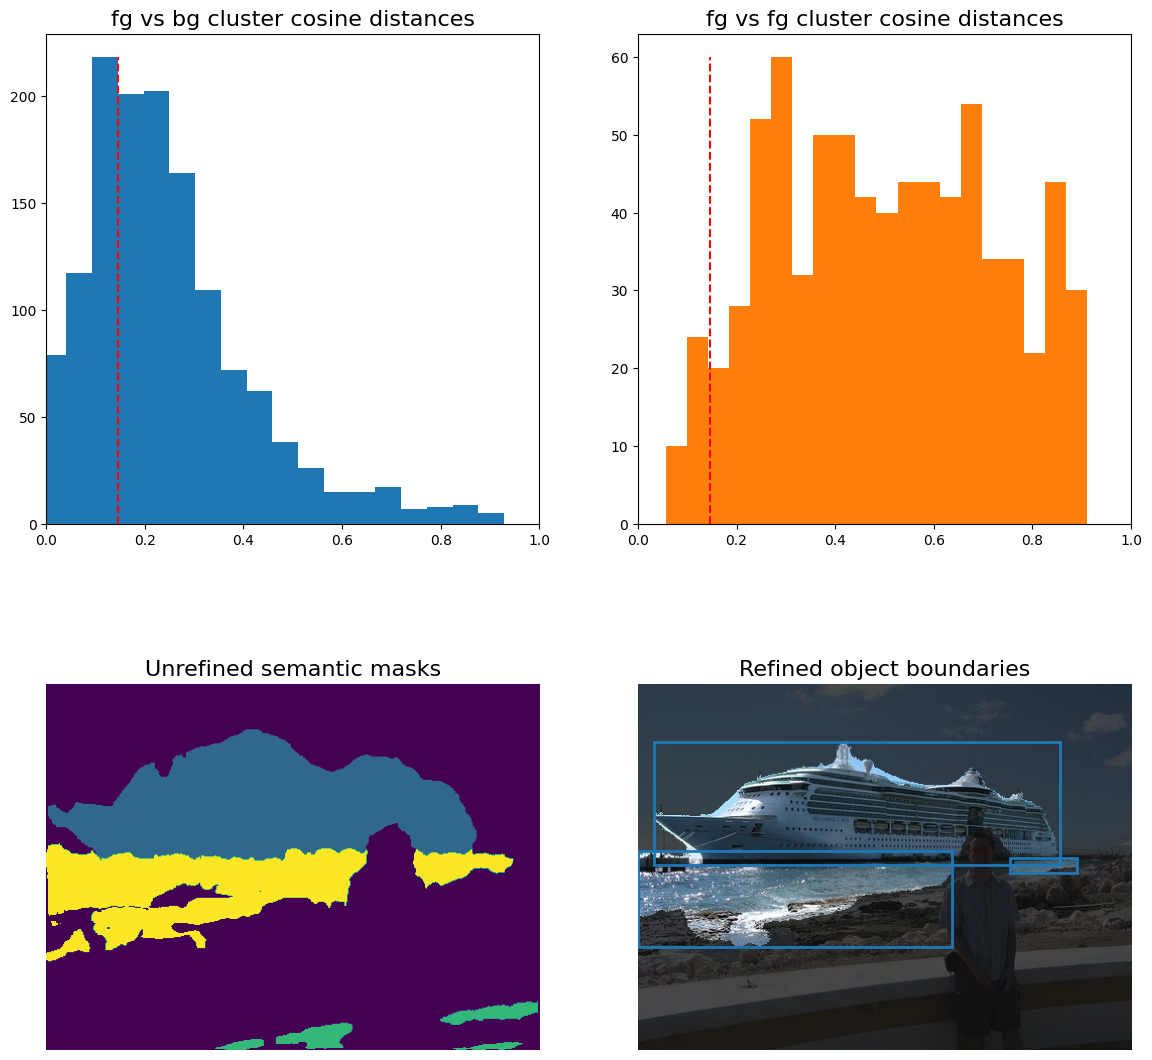

In [345]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(14, 14)
bins, edges, _ = axs[0, 0].hist(fg_bg_similarities, bins=20)
axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_title("fg vs bg cluster cosine distances", fontsize=16)
axs[0, 0].vlines(dist_cutoff, ymin=0, ymax=np.amax(bins), colors=['red'], linestyles=['dashed'])
fg_bins, fg_edges, _ = axs[0, 1].hist(fg_fg_similarities, bins=20, color='C1')
axs[0, 1].set_title("fg vs fg cluster cosine distances", fontsize=16)
axs[0, 1].vlines(dist_cutoff, ymin=0, ymax=np.amax(fg_bins), colors=['red'], linestyles=['dashed'])
axs[0, 1].set_xlim(0, 1)


axs[1, 0].imshow(out)
axs[1, 0].set_axis_off()
axs[1, 0].set_title("Unrefined semantic masks", fontsize=16)

alpha_mask = np.where(refined >= 1, [1, 1, 1, 1], [0.25, 0.25, 0.25, 0.95])
masked = (alpha_mask * img).astype(np.uint8)
axs[1, 1].imshow(masked)
axs[1, 1].set_title("Refined object boundaries", fontsize=16)
axs[1, 1].set_axis_off()

import matplotlib.patches as patches
def _draw_bboxes(bbox_list, colours: List[str], ax) -> None:
    for i, bbox in enumerate(bbox_list):
        x0, y0, x1, y1 = bbox
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            linewidth=2,
            edgecolor=colours[i],
            facecolor="none",
        )
        ax.add_patch(rect)

for bbox in class_bboxes:
    _draw_bboxes(bbox, ['C0' for i in bbox], axs[1, 1])